In [ ]:
import duckdb as db
import pandas as pd

file_path =  "../data/analysis_baseball.csv"

result0 = db.query(f"""SELECT game_date, launch_angle
                    FROM '{file_path}'
                    WHERE launch_angle IS NOT NULL
                    ORDER BY game_date ASC
                    LIMIT 5;""")
df0 = result0.to_df()
df0

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,game_date,launch_angle
0,2015-04-05,59.0
1,2015-04-05,46.0
2,2015-04-05,40.0
3,2015-04-05,23.0
4,2015-04-05,35.0


In [ ]:
result1 = db.query(f"""SELECT DISTINCT(events)
                    FROM '{file_path}'
                    WHERE description == 'hit_into_play' AND events IS NOT NULL
                    ORDER BY events;""")
                      
df1 = result1.to_df()
df1 = df1.style.set_table_styles(
    [{
        'selector': 'thead th',
        'props': [('background-color', 'lightgray'), ('color', 'black')]
    },
    {
        'selector': 'tbody td',
        'props': [('background-color', 'white'), ('color', 'black')]
    }]
)

df1

,events
0,catcher_interf
1,double
2,double_play
3,field_error
4,field_out
5,fielders_choice
6,fielders_choice_out
7,force_out
8,grounded_into_double_play
9,home_run


In [ ]:
result2 = db.query(f"""SELECT events, avg_launch_angle, top_rank, bottom_rank
                   FROM(
                   SELECT events, 
                        AVG(launch_angle) AS avg_launch_angle,
                         RANK() OVER (ORDER BY avg_launch_angle DESC) AS top_rank,
                        RANK() OVER (ORDER BY avg_launch_angle ASC) AS bottom_rank
                    FROM '{file_path}'
                    WHERE events IS NOT NULL
                    GROUP BY events
                    ORDER BY avg_launch_angle ASC) subquery
                    WHERE top_rank <= 5 OR bottom_rank <= 5;""")
                      
df2 = result2.to_df()
df2

,events,avg_launch_angle,top_rank,bottom_rank
0,sac_bunt,-33.387818,17,1
1,sac_bunt_double_play,-32.000000,16,2
2,fielders_choice_out,-16.289474,15,3
3,fielders_choice,-15.391196,14,4
4,force_out,-12.546694,13,5
5,double_play,17.550676,5,13
6,triple,19.262448,4,14
7,home_run,28.710837,3,15
8,sac_fly,31.918208,2,16
9,sac_fly_double_play,32.672131,1,17


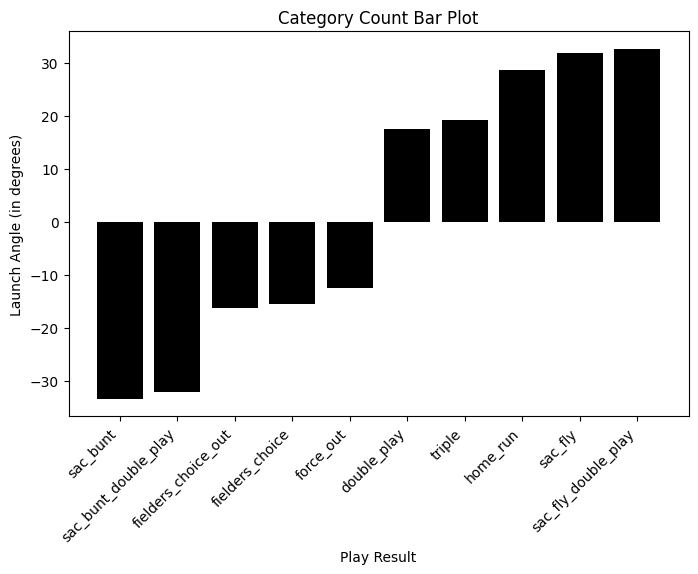

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(df2['events'], df2['avg_launch_angle'], color='black')

plt.xlabel('Play Result')
plt.ylabel('Launch Angle (in degrees)')
plt.title('Category Count Bar Plot')

plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
result3 = db.query(f"""SELECT events, AVG(runs_scored) as avg_runs_scored, AVG(launch_angle) as avg_launch_angle,
                        RANK() OVER (ORDER BY avg_runs_scored DESC) AS top_rank,
                        RANK() OVER (ORDER BY avg_runs_scored ASC) AS bottom_rank
                   FROM
                   (SELECT events, 
                                launch_angle,
                                bat_score AS runs,
                                LEAD(bat_score) OVER (PARTITION BY game_pk,  inning_topbot 
                                    ORDER BY  game_pk, at_bat_number ASC, pitch_number ASC) AS runs2,
                                COALESCE(runs2 - runs, 0) AS runs_scored,
                                game_pk, at_bat_number, pitch_number
                    FROM '{file_path}') subquery
                    WHERE events IS NOT NULL
                    GROUP BY events;""")
                      
df3 = result3.to_df()
df3

,events,avg_runs_scored,avg_launch_angle,top_rank,bottom_rank
0,triple_play,0.000000,7.666667,21,1
1,sac_bunt_double_play,0.000000,-32.000000,21,1
2,strikeout,0.000340,NaN,20,3
3,double_play,0.005551,17.550676,19,4
4,field_out,0.007007,16.028030,18,5
5,strikeout_double_play,0.008108,NaN,17,6
6,truncated_pa,0.008637,NaN,16,7
7,walk,0.019306,NaN,15,8
8,grounded_into_double_play,0.030024,-9.269417,14,9
9,hit_by_pitch,0.034653,NaN,13,10


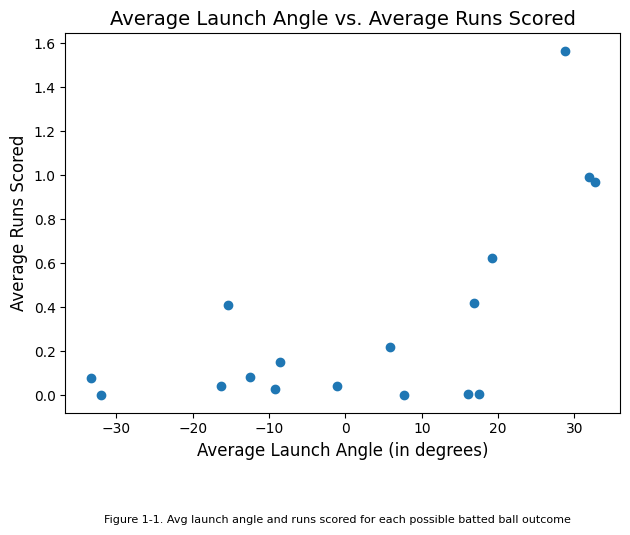

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df3['avg_launch_angle'], df3['avg_runs_scored'])

plt.xlabel('Average Launch Angle (in degrees)', fontsize=12)
plt.ylabel('Average Runs Scored', fontsize=12)
plt.title('Average Launch Angle vs. Average Runs Scored', fontsize=14)
plt.figtext(0.9, -0.1, "Figure 1-1. Avg launch angle and runs scored for each possible batted ball outcome", wrap=False, ha="right", fontsize=8)


plt.tight_layout()

plt.show()


In [12]:
result4 = db.query(f"""SELECT CAST(launch_angle_bins AS VARCHAR) AS launch_angle_bins, ops
                   FROM
                   (SELECT FLOOR(launch_angle/10) * 10 AS launch_angle_bins, 
                        AVG(CASE 
                                WHEN events == 'single' THEN 1
                                WHEN events == 'double' THEN 2
                                WHEN events == 'triple' THEN 3
                                WHEN events == 'home_run' THEN 4
                                ELSE 0
                            END +
                            CASE
                                WHEN events IN ('single', 'double', 'triple', 'home_run') THEN 1
                                ELSE 0
                            END) AS ops
                        FROM '{file_path}'
                        WHERE launch_angle IS NOT NULL AND events IS NOT NULL
                        GROUP BY launch_angle_bins
                        ORDER BY launch_angle_bins ASC) subquery;""")

                      
df4 = result4.to_df()
df4


,launch_angle_bins,ops
0,-90.0,0.251656
1,-80.0,0.409587
2,-70.0,0.532101
3,-60.0,0.516000
4,-50.0,0.346905
5,-40.0,0.172538
6,-30.0,0.179080
7,-20.0,0.275857
8,-10.0,0.505852
9,0.0,0.997262


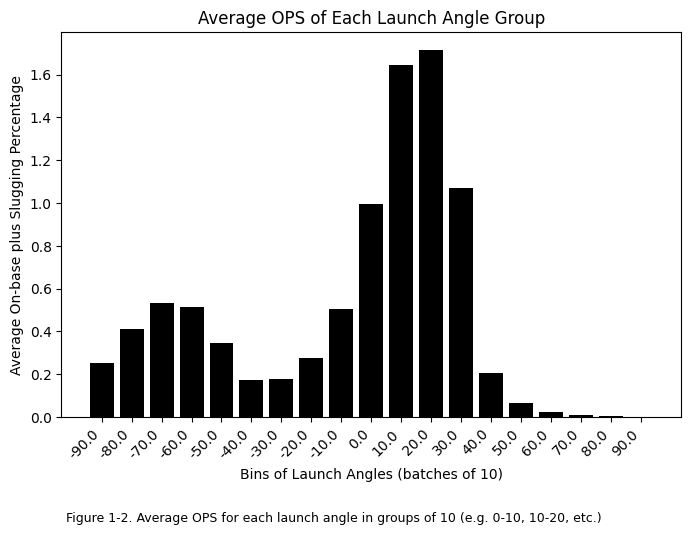

In [21]:
plt.figure(figsize=(8, 5))
plt.bar(df4['launch_angle_bins'], df4['ops'], color='black')

plt.xlabel('Bins of Launch Angles (batches of 10)')
plt.ylabel('Average On-base plus Slugging Percentage')
plt.title('Average OPS of Each Launch Angle Group')
plt.figtext(0.8, -0.1, "Figure 1-2. Average OPS for each launch angle in groups of 10 (e.g. 0-10, 10-20, etc.)", wrap=False, ha="right", fontsize=9)


plt.xticks(rotation=45, ha='right')

plt.show()

In [24]:
result5 = db.query(f"""SELECT FLOOR(launch_angle) AS launch_angle_bins, 
                        AVG(CASE 
                                WHEN events == 'single' THEN 1
                                WHEN events == 'double' THEN 2
                                WHEN events == 'triple' THEN 3
                                WHEN events == 'home_run' THEN 4
                                ELSE 0
                            END +
                            CASE
                                WHEN events IN ('single', 'double', 'triple', 'home_run') THEN 1
                                ELSE 0
                            END) AS ops
                        FROM '{file_path}'
                        WHERE launch_angle IS NOT NULL AND events IS NOT NULL
                        GROUP BY launch_angle_bins
                        ORDER BY launch_angle_bins ASC;""")

                      
df5 = result5.to_df()
df5

,launch_angle_bins,ops
0,-90.0,0.000000
1,-89.0,0.200000
2,-88.0,0.315789
3,-87.0,0.347826
4,-86.0,0.127660
...,...,...
176,86.0,0.000000
177,87.0,0.000000
178,88.0,0.000000
179,89.0,0.000000


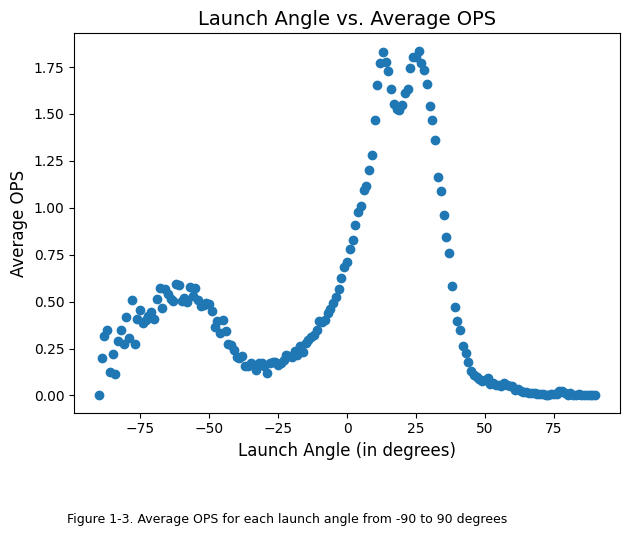

In [27]:
import matplotlib.pyplot as plt

plt.scatter(df5['launch_angle_bins'], df5['ops'])

plt.xlabel('Launch Angle (in degrees)', fontsize=12)
plt.ylabel('Average OPS', fontsize=12)
plt.title('Launch Angle vs. Average OPS', fontsize=14)
plt.figtext(0.8, -0.1, "Figure 1-3. Average OPS for each launch angle from -90 to 90 degrees", wrap=False, ha="right", fontsize=9)


plt.tight_layout()

plt.show()

In [ ]:
result6 = db.query(f"""SELECT launch_angle, 
                        CASE 
                                WHEN events == 'single' THEN 1
                                WHEN events == 'double' THEN 2
                                WHEN events == 'triple' THEN 3
                                WHEN events == 'home_run' THEN 4
                                ELSE 0
                            END +
                        CASE
                                WHEN events IN ('single', 'double', 'triple', 'home_run') THEN 1
                                ELSE 0
                            END AS ops
                        FROM '{file_path}'
                        WHERE launch_angle IS NOT NULL AND events IS NOT NULL;""")

                      
model_data = result6.to_df()

In [ ]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
torch.manual_seed(42)


tensor_data = torch.tensor(model_data.to_numpy(), dtype=torch.float32)
X = tensor_data[:, 0].unsqueeze(1) 
y = tensor_data[:, 1].unsqueeze(1)

total_size = len(tensor_data)
train_size = int(0.7 * total_size)   
val_size = int(0.15 * total_size)    
test_size = total_size - train_size - val_size 

train_data, val_data, test_data = random_split(tensor_data, [train_size, val_size, test_size])

batch_size = 512

train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size)


model = nn.Linear(1, 1)
loss_fn = F.mse_loss
loss = loss_fn(model(X), y)
print(loss)

opt = torch.optim.SGD(model.parameters(), lr=1e-5)


def fit(num_epochs, model, loss_fn, opt, train_dl):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            
            xb = xb.to(torch.float32) 
            yb = yb.to(torch.float32)

            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

tensor(172.2723, grad_fn=<MseLossBackward0>)


In [130]:
torch.manual_seed(42)

tensor_data = torch.tensor(model_data.to_numpy(), dtype=torch.float32)

X = tensor_data[:, 0].unsqueeze(1)  
y = tensor_data[:, 1].unsqueeze(1)  

total_size = len(X)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

dataset = TensorDataset(X, y)
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [131]:
batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [132]:
model = nn.Linear(1, 1)
loss_fn = F.mse_loss
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

In [133]:
def fit(num_epochs, model, loss_fn, opt, train_dl):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            xb, yb = xb.to(torch.float32), yb.to(torch.float32)  

            pred = model(xb)  
            loss = loss_fn(pred, yb)  
            
            opt.zero_grad()  
            loss.backward()  
            opt.step() 
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [134]:
fit(50, model, loss_fn, opt, train_loader)

Epoch [10/50], Loss: 1.9034
Epoch [20/50], Loss: 1.9022
Epoch [30/50], Loss: 1.8776
Epoch [40/50], Loss: 1.9483
Epoch [50/50], Loss: 1.6094


In [135]:
preds = model(X)
preds

tensor([[0.2993],
        [0.3984],
        [0.5737],
        ...,
        [0.2840],
        [0.2307],
        [0.3755]], grad_fn=<AddmmBackward0>)

In [ ]:
y